In [1]:
import RunFullMap
import numpy as np
import scipy.linalg
import keras.backend as K
import tensorflow as tf
import sklearn.manifold
import sklearn.metrics

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

from polynomialcurve import PolynomialPointCurve
import LaplacianEigenmaps




Using TensorFlow backend.


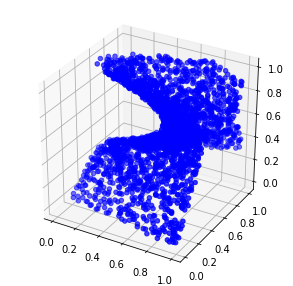

In [2]:
polycurve = PolynomialPointCurve(seed=3141, dimension=3, avg_dims_per_term=1, avg_power_per_dim=2, num_terms=3, avg_mono_term_power=1, max_coeff=2)
#3141 is a good seed
polycurve.compute_threshold(.1)
data = polycurve.gen_noisy_points(3000)
fig=plt.figure(figsize=(5,5))
a1=fig.add_subplot(111, projection='3d')
a1.scatter(data[:,0], data[:,1], data[:,2], color='blue')
plt.show()

In [3]:
data = polycurve.gen_noisy_points(3000)

In [4]:
T_THRESH = 2000
train = data[:T_THRESH]
test = data[T_THRESH:]

In [9]:
def graph_train_test(pred_net, train, test, pos_weight=1):
    fig = plt.figure(figsize=(10,5))
    train_pred = pred_net.predict(train)
    test_pred = pred_net.predict(test)
    a1 = fig.add_subplot(121, projection='3d')
    #a1.scatter(train[:,0], train[:,1],train[:,2], color='blue')
    a1.scatter(train_pred[:,0], train_pred[:,1],train_pred[:,2], color='red')
    a1.set_title('Train data')
    a2 = fig.add_subplot(122, projection='3d')
    #a2.scatter(test[:,0], test[:,1], test[:,2], color='blue')
    a2.scatter(test_pred[:,0], test_pred[:,1], test_pred[:,2], color='red')
    a2.set_title('Test data')
    print ("Train: Original error " + str(polycurve.compute_error(train, orig_points = train, error_type = 'evaluative')) 
       + "\nTrain evaluative error " + str(polycurve.compute_error(train_pred, orig_points = train, error_type = 'evaluative'))
       + "\nTrain positional error " + str(polycurve.compute_error(train_pred, orig_points = train, error_type = 'positional')))
    print ("Test: Original error " + str(polycurve.compute_error(test, orig_points = test, error_type = 'evaluative')) 
       + "\nTrain evaluative error " + str(polycurve.compute_error(test_pred, orig_points = test, error_type = 'evaluative'))
       + "\nTrain positional error " + str(polycurve.compute_error(test_pred, orig_points = test, error_type = 'positional')))    

Gpu available:  True


W0415 11:04:15.940275 140496587216704 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0415 11:04:15.940963 140496587216704 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0415 11:04:15.942309 140496587216704 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0415 11:04:15.953565 140496587216704 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.

W0415 11:04:15.9

Done embedding
Done encoder
Done decoder


W0415 11:04:47.170465 140496587216704 deprecation_wrapper.py:119] From /home/stephen/Desktop/diffusion_net/RunFullMap.py:163: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Original method:
Train: Original error 1.4298008964219444 , Train evaluative error 0.10167327315018397 , Train positional error 0.06415202480015773
Test: Original error 1.4685132851244909 , Train evaluative error 0.10030172740433714 , Train positional error 0.06746226342893603


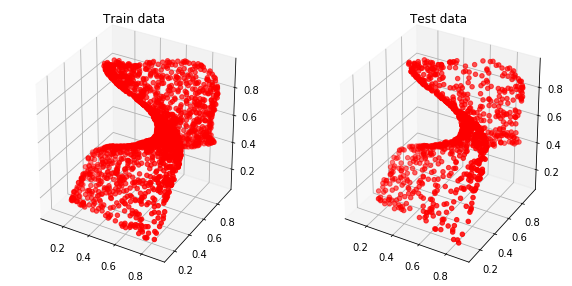

In [6]:
norm_net = RunFullMap.DiffusionNet(train, 2, embedding='normal', visual=False)

Original method:
Train: Original error 1.4298008964219444
Train evaluative error 0.10167327315018397
Train positional error 0.06415202480015773
Test: Original error 1.4685132851244909
Train evaluative error 0.10030172740433714
Train positional error 0.06746226342893603


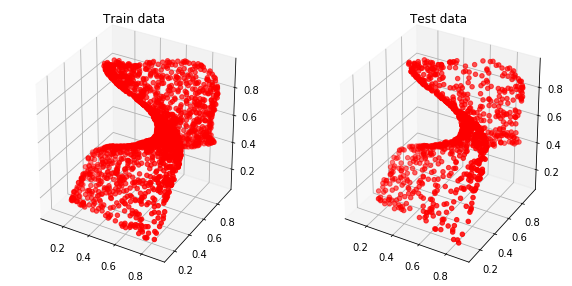

In [10]:
print("Original method:")
graph_train_test(norm_net, train, test, pos_weight=2)

Gpu available:  True
Using no eigenvalue scaling
[0.99780985 0.99626468]
Done embedding
Done encoder
Done decoder
Scaling-free method
Train: Original error 1.4298008964219444 , Train evaluative error 0.13560688488726957 , Train positional error 0.06060898231308958
Test: Original error 1.4685132851244909 , Train evaluative error 0.13994221938772747 , Train positional error 0.06444874499374742


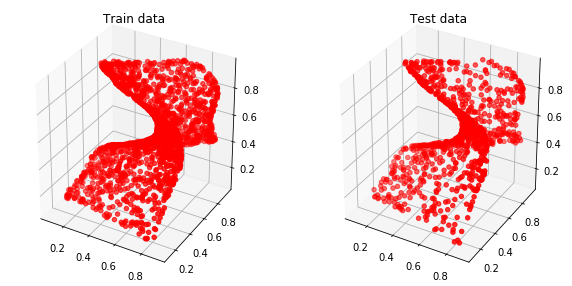

In [7]:
pow_net = RunFullMap.DiffusionNet(train, 2, embedding='no_eig_scaling', visual=False)

In [ ]:
print("Scaling-free method")
graph_train_test(pow_net, train, test, pos_weight=2)

Gpu available:  True
Using laplacian embedding
[349.99595926 345.80245186]
Done embedding
Done encoder
Done decoder
Laplacian method:
Train: Original error 1.4298008964219444 , Train evaluative error 0.09626430865862062 , Train positional error 3.0014596085926613
Test: Original error 1.4685132851244909 , Train evaluative error 0.0962691594672099 , Train positional error 3.0343126126884825


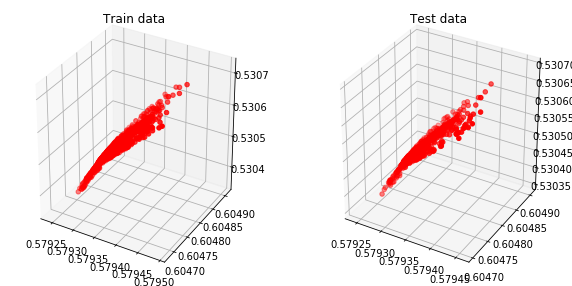

In [8]:
lap_net = RunFullMap.DiffusionNet(train, 2, embedding='laplacian', visual=False)

In [ ]:
print("Laplacian method:")
graph_train_test(lap_net, train, test, pos_weight=2)